<a href="https://colab.research.google.com/github/jkeza1/facemask-classification-pipeline/blob/main/facemask_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Mask Detection using CNN - Machine Learning Pipeline

**Objective:**  
Build, evaluate, and deploy a convolutional neural network (CNN) model to classify images into three categories:  
- mask worn incorrectly  
- with mask  
- without mask  

Demonstrate the full ML pipeline including data processing, model creation, evaluation, retraining, and deployment readiness.


In [22]:
 #INSTALL DEPENDENCIES

!pip install tensorflow
!pip install keras
!pip install matplotlib
!pip install seaborn
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install opencv-python
!pip install numpy pandas matplotlib seaborn scikit-learn tensorflow opencv-python imutils



In [23]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import cv2
import imutils
from imutils import paths
import pickle
import time
import json

In [24]:
original_dataset_dir = r"C:\Users\HP\OneDrive\Desktop\project\facemask-classification-pipeline\Dataset"


In [25]:
original_dataset_dir = r"C:\Users\HP\OneDrive\Desktop\project\facemask-classification-pipeline\Dataset"
base_dir = r"C:\Users\HP\OneDrive\Desktop\project\facemask-classification-pipeline\Dataset_Split"

classes = ['mask_weared_incorrect', 'with_mask', 'without_mask']


In [26]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 8

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2, rotation_range=15, zoom_range=0.2, horizontal_flip=True)

train_generator = datagen.flow_from_directory(
    original_dataset_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    original_dataset_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

class_names = list(train_generator.class_indices.keys())


Found 7188 images belonging to 3 classes.
Found 1794 images belonging to 3 classes.


In [27]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


c:\Users\HP\OneDrive\Desktop\project\facemask-classification-pipeline\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,707 (28.20 MB)

 Trainable params: 7,392,707 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


Epoch 1/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 225s 250ms/step - accuracy: 0.8126 - loss: 0.4763 - val_accuracy: 0.9047 - val_loss: 0.2634
Epoch 2/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 264s 294ms/step - accuracy: 0.8996 - loss: 0.2832 - val_accuracy: 0.9404 - val_loss: 0.1961
Epoch 3/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 197s 219ms/step - accuracy: 0.9239 - loss: 0.2315 - val_accuracy: 0.8930 - val_loss: 0.2980
Epoch 4/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 261s 290ms/step - accuracy: 0.9313 - loss: 0.1923 - val_accuracy: 0.9459 - val_loss: 0.1690
Epoch 5/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 214s 238ms/step - accuracy: 0.9375 - loss: 0.1836 - val_accuracy: 0.9548 - val_loss: 0.1508
Epoch 6/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 244s 271ms/step - accuracy: 0.9427 - loss: 0.1635 - val_accuracy: 0.9426 - val_loss: 0.1819
Epoch 7/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 208s 231ms/step - accuracy: 0.9467 - loss: 0.1533 - val_accuracy: 0.9576 - val_loss: 0.1225
Epoch 8/10
899/899 ━━━━━━━━━━━━━━━━━━━━ 215s 239ms/step - accuracy: 0.9542 -

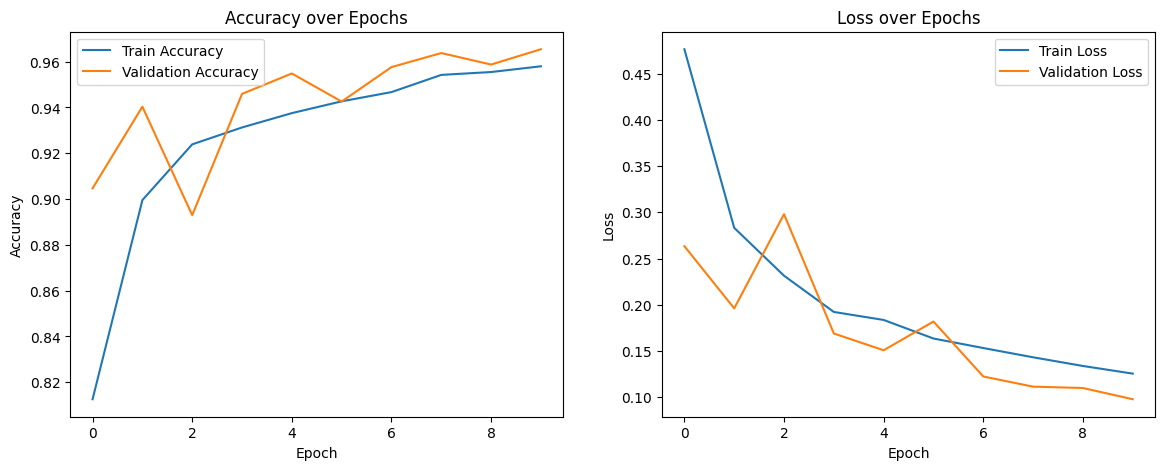

225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 64ms/step


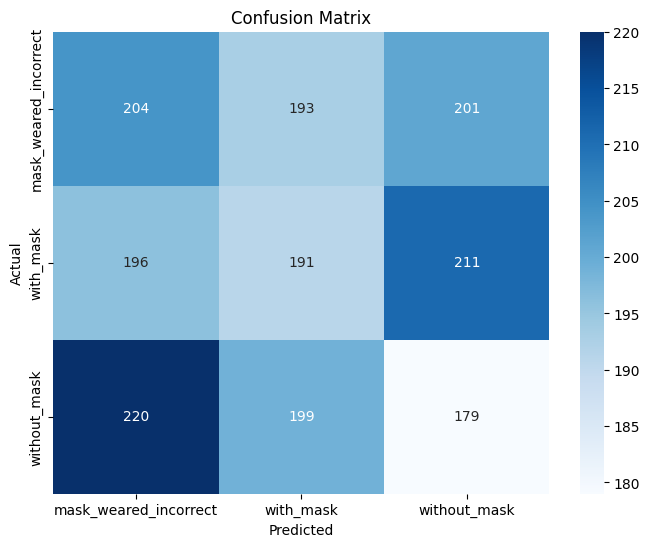

Classification Report:

                       precision    recall  f1-score   support

mask_weared_incorrect       0.33      0.34      0.33       598
            with_mask       0.33      0.32      0.32       598
         without_mask       0.30      0.30      0.30       598

             accuracy                           0.32      1794
            macro avg       0.32      0.32      0.32      1794
         weighted avg       0.32      0.32      0.32      1794



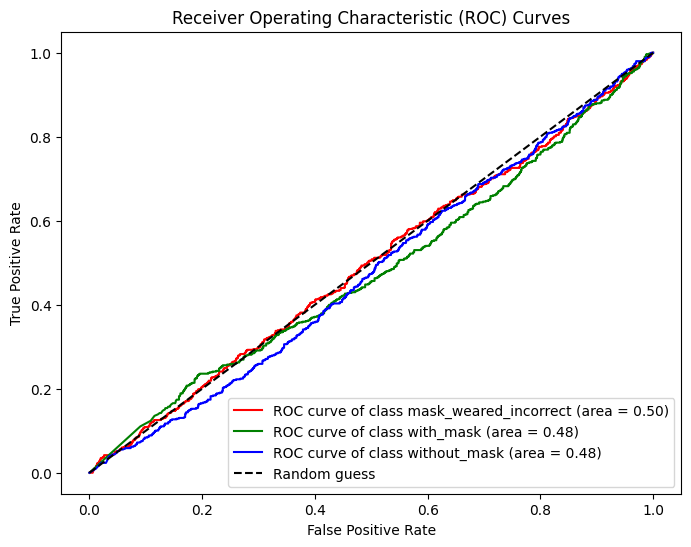

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from itertools import cycle

# --- 1. Plot Accuracy and Loss Curves ---
plt.figure(figsize=(14,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# --- 2. Confusion Matrix and Classification Report ---

# Reset the validation generator (important before prediction)
val_generator.reset()

# Predict the classes for validation set
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Get true labels from generator
y_true = val_generator.classes
labels = list(val_generator.class_indices.keys())

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=labels))

# --- 3. ROC Curve for Multi-class Classification ---

# One-hot encode true labels
num_classes = len(labels)
y_true_onehot = np.eye(num_classes)[y_true]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_onehot[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8,6))
colors = cycle(['red', 'green', 'blue', 'orange', 'purple'])  # Extend if >5 classes

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label=f'ROC curve of class {labels[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()


In [40]:
model.save("../models/mask_detection_model.h5")


In [46]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

# Load the model (adjust path if needed)
model = load_model(r"C:\Users\HP\OneDrive\Desktop\project\facemask-classification-pipeline\models\mask_detection_model.h5")

# Class names in correct order (adjust to your training)
class_names = ['mask_weared_incorrect', 'with_mask', 'without_mask']

# Path to test image
img_path = r"C:\Users\HP\OneDrive\Desktop\project\facemask-classification-pipeline\Dataset\with_mask\1.png"

# Load and preprocess the image
img = load_img(img_path, target_size=(128, 128))
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
prediction = model.predict(img_array)
predicted_class = class_names[np.argmax(prediction)]

print("Predicted class:", predicted_class)


c:\Users\HP\OneDrive\Desktop\project\facemask-classification-pipeline\.venv\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step
Predicted class: with_mask


In [47]:
def retrain_model(model_path, new_data_dir, save_path):
    model = load_model(model_path, compile=False)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    retrain_datagen = ImageDataGenerator(rescale=1./255)
    retrain_generator = retrain_datagen.flow_from_directory(
        new_data_dir,
        target_size=IMG_SIZE,
        batch_size=32,
        class_mode='categorical'
    )

    early_stop = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True)

    model.fit(retrain_generator, epochs=5, callbacks=[early_stop])
    model.save(save_path)
    print("✅ Retrained model saved.")


In [49]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Evaluate model on validation set
loss, accuracy = model.evaluate(val_generator)
print(f"Accuracy: {accuracy:.2f}, Loss: {loss:.2f}")

# Get predictions for validation set
y_prob = model.predict(val_generator)
y_pred = np.argmax(y_prob, axis=1)

# Calculate additional metrics
print("Precision:", precision_score(val_generator.classes, y_pred, average='weighted'))
print("Recall:", recall_score(val_generator.classes, y_pred, average='weighted'))
print("F1 Score:", f1_score(val_generator.classes, y_pred, average='weighted'))


225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 65ms/step - accuracy: 0.9654 - loss: 0.0975
Accuracy: 0.97, Loss: 0.10
225/225 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step
Precision: 0.3410273713924452
Recall: 0.3411371237458194
F1 Score: 0.341049990830203


In [50]:
def save_metadata(model, dataset_path):
    metadata = {
        "timestamp": datetime.datetime.now().isoformat(),
        "classes": class_names,
        "val_accuracy": max(history.history['val_accuracy']),
        "val_loss": min(history.history['val_loss']),
        "dataset_size": sum([len(files) for _, _, files in os.walk(dataset_path)])
    }
    with open("model_metadata.json", "w") as f:
        json.dump(metadata, f)
